In [ ]:
from find_optimal_traj import *
from utils import js_divergence
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from network import Network

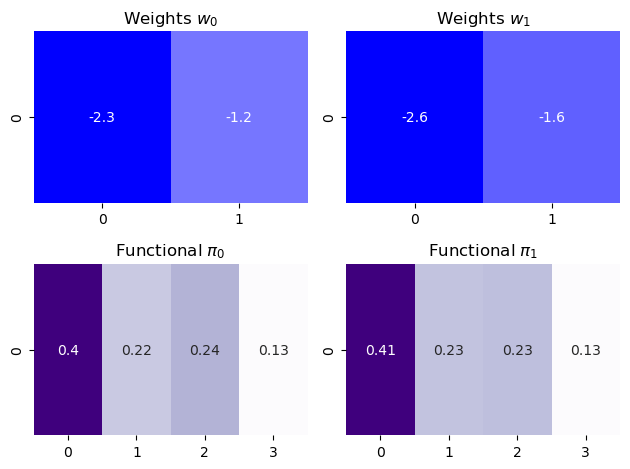

In [13]:
n = 2
d = n**2 - n
device = 'cpu'
w0 = torch.randn(d)
w1 = w0 + torch.randn(d) * 0.5
s = torch.randn(n)
net = Network(n, device)
pi0 = net(w0, s).detach().cpu()    
pi1 = net(w1, s).detach().cpu()
annot = d <= 5

fig, ax = plt.subplots(2,2)
sns.heatmap(w0.reshape(1,-1).detach().numpy(), ax=ax[0,0], cbar=False, annot=annot, cmap='bwr', center=0)
sns.heatmap(w1.reshape(1,-1).detach().numpy(), ax=ax[0,1], cbar=False, annot=annot, cmap='bwr', center=0)
sns.heatmap(pi0.reshape(1,-1).detach().numpy(), ax=ax[1,0], cbar=False, annot=annot, cmap='Purples')
sns.heatmap(pi1.reshape(1,-1).detach().numpy(), ax=ax[1,1], cbar=False, annot=annot, cmap='Purples')
ax[0,0].set_title('Weights $w_0$')
ax[0,1].set_title('Weights $w_1$')
ax[1,0].set_title('Functional $\\pi_0$')
ax[1,1].set_title('Functional $\\pi_1$')
plt.tight_layout()
plt.show()

In [ ]:
sol = solve_el_bvp(w0, w1, net, s, alpha=0.99, T=1.0, n_points=200)
print(sol.message)
print(f'Success: {sol.success}')

(2, 598) (2, 598) (598,)


Text(0.5, 1.0, 'Optimal Weight Trajectories')

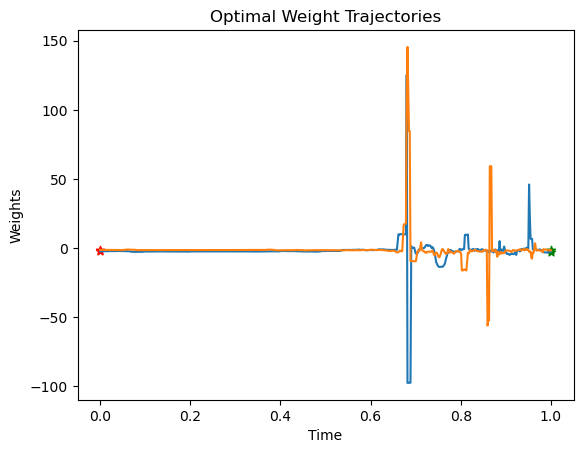

In [ ]:
w_traj = sol.y[:d, :] 
v_traj = sol.y[d:, :]
t = sol.x
print(w_traj.shape, v_traj.shape, t.shape)

plt.figure()
for i in range(d):
    plt.plot(t, w_traj[i, :], label=f'$w_{i}$')
    plt.scatter(t[0], w0[i].item(), color='red', marker='*')     # start point
    plt.scatter(t[-1], w1[i].item(), color='green', marker='*')  # end point
plt.xlabel('Time')
plt.ylabel('Weights')
plt.title('Optimal Weight Trajectories')
plt.legend()
plt.show()

In [ ]:
# compute the functional dists across the trajectory
def compute_functional_dist(net, w_traj, s):
    pi_traj = []
    for i in range(w_traj.shape[1]):
        w = torch.tensor(w_traj[:, i], dtype=torch.float32)
        pi = net(w, s).detach().cpu().numpy()
        pi_traj.append(pi)
    return np.array(pi_traj)

# calc the pairwise djs matrix
def compute_djs_matrix(pi_traj):
    n_points = pi_traj.shape[0]
    djs_matrix = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            djs_matrix[i, j] = torch.sqrt(js_divergence(pi_traj[i], pi_traj[j])+eps)
    return djs_matrix

# calculate MDS embedding
from sklearn.manifold import MDS
def compute_mds_embedding(djs_matrix, n_components=2):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=0)
    embedding = mds.fit_transform(djs_matrix)
    return embedding

# plot the MDS embedding
pi_traj = compute_functional_dist(net, w_traj, s)
djs_matrix = compute_djs_matrix(pi_traj)
embedding = compute_mds_embedding(djs_matrix, n_components=2)
plt.figure()
plt.plot(embedding[:, 0], embedding[:, 1], marker='o', label=r'$\phi(w(t))$ trajectory')
plt.scatter(embedding[0, 0], embedding[0, 1], color='red', marker='*', s=200, label='Start')     # start point
plt.scatter(embedding[-1, 0], embedding[-1, 1], color='green', marker='*', s=200, label='End')  # end point
plt.title('MDS Embedding of Functional Trajectory')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.legend()